In [5]:
# [STAR] All the Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from pathlib import Path
import ast
import pandas as pd
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import re
import cv2

import random

import csv
from scipy import ndimage, misc
from tqdm import tqdm

In [7]:
# [OLD] Code for classification

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/media/yu-hao/WindowsData/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)

In [19]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class MyAttrCateModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model    = models.resnet18(pretrained=True)
        self.model.fc = Identity()
        
        self.attr_layer = nn.Linear(512, 26)
        self.cate_layer = nn.Linear(512, 50)
    
    def forward(self, x):
        out1     = self.model(x)
        attr_out = self.attr_layer(out1)
        cate_out = self.cate_layer(out1)
        return attr_out, cate_out

attr_cate_model = MyAttrCateModel()
x      = torch.randn(1, 3, 224, 224)
output = attr_cate_model(x)
print(output[0].shape, output[1].shape)

#print(model)
#model_ft = model_ft.to(device)

torch.Size([1, 26]) torch.Size([1, 50])


In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
# [STAR] All the functions for reading the data for Wheat Dataset

from scipy import ndimage

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    r1 = [float(x) for x in r]
    r = r1
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df = pd.read_csv('/media/yu-hao/WindowsData/WheatDataset/train.csv')
train_df.shape

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

temp = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
#train_df[['x', 'y', 'w', 'h']] = 
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = temp[:, 0]#train_df['x'].astype(np.float)
train_df['y'] = temp[:, 1]#train_df['y'].astype(np.float)
train_df['w'] = temp[:, 2]#train_df['w'].astype(np.float)
train_df['h'] = temp[:, 3]#train_df['h'].astype(np.float)

# df['bbox'] = df['bbox'].apply(lambda x: np.array(x))
# x = np.array(list(df['bbox']))
# print(x)
# for i, dim in enumerate(['x', 'y', 'w', 'h']):
#     df[dim] = x[:, i]

# # df.drop('bbox', axis=1, inplace=True)
# #df.head()

class WheatDatasetOld(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, transforms = None):
        super().__init__()
        
        self.df = df
        self.image_ids  = self.df['image_id'].unique()
        self.image_dir  = Path(image_dir)
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records  = self.df[self.df['image_id'] == image_id]
        
        im_name = image_id + '.jpg'
        img = Image.open(self.image_dir/im_name).convert("RGB")
        img = T.ToTensor()(img)
        
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        #print('boxes shape is ',boxes.shape)
        boxes = torch.Tensor(boxes).to(device)#, device='cuda:0')#dtype=torch.int64)
        
        labels = torch.ones((records.shape[0], ), dtype=torch.int64)
        
        target = {}
        target['boxes']  = boxes
        target['labels'] = labels
        target['image_id']  = torch.tensor([idx])
        
        return img, target, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

class DBTDataset(torch.utils.data.Dataset):
    def __init__(self, train_set = 1, transforms = None):
        super().__init__()
        
        self.counter = 0
        if train_set == 1:
            self.train_start  = 0
            self.train_end    = 150
        else:
            self.train_start  = 150
            self.train_end    = 200
        
        self.train_set = train_set
        suffix_str  = ''#random.choice(['_m2', '_m1', '_p1', '_p2', ''])
        print('READING NEW FILE >> ', suffix_str, ' <<')
        self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx'+suffix_str+'.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
        self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy'+suffix_str+'.npy')[self.train_start:self.train_end]
        self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx'+suffix_str+'.npy')[self.train_start:self.train_end]
        self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy'+suffix_str+'.npy')[self.train_start:self.train_end]
        self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
        self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
        
        
#         self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
#         self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy.npy')[self.train_start:self.train_end]
#         self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx.npy')[self.train_start:self.train_end]
#         self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy.npy')[self.train_start:self.train_end]
#         self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr.npy')[self.train_start:self.train_end]
#         self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr.npy')[self.train_start:self.train_end]
        
        self.transforms1 = A.Compose(
                                    [A.HorizontalFlip(p=0.5),  A.VerticalFlip(p=0.5), ],
                                     #A.Downscale(scale_min=0.75, scale_max=0.75,interpolation=3),],
                                    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
                                   )
        
    def __getitem__(self, idx):
        self.counter = self.counter+1
        #if self.counter % 10 == 0:
        #    print('Counter is ', self.counter)
        
#         if self.train_set == 1 and self.counter % 150 == 0 and random.random() < 0.2:
#             suffix_str  = random.choice([ '_m1', '_p1', ''])
#             print('READING NEW FILE >> ', suffix_str, ' <<')
#             self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx'+suffix_str+'.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
#             self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
                
        img = self.trainx[idx, 0].astype('float32')/60000.0
        img[img > 1] = 1
        img = ndimage.interpolation.zoom(img, 0.25)
        img = np.expand_dims(img, 0)
        img = np.concatenate([img, img, img], axis=0)
        #if(0):
        if(self.train_set == 1):
            img = np.moveaxis(img, 0, -1)
        
        boxes = np.array([self.coordx[idx]/4, self.coordy[idx]/4, self.width_arr[idx]/4, self.height_arr[idx]/4])#records[['x', 'y', 'w', 'h']].values
        boxes = np.expand_dims(boxes, axis=0)
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        
        area = self.width_arr[idx] * self.height_arr[idx]
        area = torch.Tensor(area)
        
        # there is only one class
        labels =  torch.ones((1,)).type(torch.int64)
        
        if(self.train_set == 1):
        #if(0):
            transformed = self.transforms1(image=img, bboxes=boxes, labels=labels)
            image    = transformed['image']
            boxes    = np.array(transformed['bboxes'])
            img      = np.moveaxis(image, 2, 0)
        
        # suppose all instances are not crowd
        iscrowd = torch.Tensor(np.array([0])).type(torch.int64)
        
        target              = {}
        target['boxes']     = torch.Tensor(boxes)
        target['labels']    = labels
        target['image_id']  = torch.tensor([idx])
        target['area']      = area
        target['iscrowd']   = iscrowd
        
        return img, target, idx
    
    def __len__(self):
        return self.trainx.shape[0]

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [3]:
# [STAR] Wheat Dataset and Model Creation

image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

print(valid_df.shape, train_df.shape)

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

def collate_fn(batch):
    return tuple(zip(*batch))

DIR_INPUT = '/media/yu-hao/WindowsData/WheatDataset'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST  = f'{DIR_INPUT}/test'

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

(25006, 8) (122787, 8)


In [7]:
# [STAR] DBT Dataset and Model Creation

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset     = DBTDataset(train_set=1)
valid_dataset     = DBTDataset(train_set=0)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=1, collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1, collate_fn=collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model       = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params       = [p for p in model.parameters() if p.requires_grad]
optimizer    = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0001)
lr_scheduler = None

READING NEW FILE >>    <<
READING NEW FILE >>    <<


In [ ]:
# [STAR] Training loop for DBT dataset
optimizer    = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0001)

# params       = [p for p in model.parameters() if p.requires_grad]
# optimizer    = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0001)
# lr_scheduler = None

loss_hist     = Averager()
val_loss_hist = Averager()

prev_min   = 1000
num_epochs = 50
for epoch in range(num_epochs):
    loss_hist.reset()
    loss_hist.reset()
    
    model.train()
    itr = 1
    for images, targets, image_ids in train_data_loader:
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))
        
        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses     = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    with torch.no_grad():
        for images, targets, image_ids in valid_data_loader:
            new_images  = []
            for img in images:
                new_images.append(torch.Tensor(img).to(device))

            images    = new_images
            targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            #print(loss_dict)

            losses     = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            val_loss_hist.send(loss_value)

            if itr % 50 == 0:
                print(f"Validation Iteration #{itr} loss: {loss_value}")
            itr = itr+1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} Train loss: {loss_hist.value}")
    print(f"Epoch #{epoch} Val   loss: {val_loss_hist.value}")
    
    if val_loss_hist.value < prev_min:
        print('Saving the model ', prev_min, val_loss_hist.value)
        torch.save(model.state_dict(), 'fasterrcnn_resnet50_dbt26.pth')
        prev_min = val_loss_hist.value

In [9]:
# [STAR] For printing the loss of the trained model

# fasterrcnn_resnet50_dbt7.pth  0.24080992616713048
# fasterrcnn_resnet50_dbt8.pth  0.1653416310250759
# fasterrcnn_resnet50_dbt9.pth  0.17630461007356643
# fasterrcnn_resnet50_dbt10.pth 0.17438715264201166
# fasterrcnn_resnet50_dbt11.pth 0.16590506657958032

all_target = []
all_scores  = []
val_loss_hist = Averager()
itr = 1

#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt26.pth'))
model.train()

with torch.no_grad():
    for images, targets, image_ids in valid_data_loader:
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))

        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        #print(loss_dict)

        losses     = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_hist.send(loss_value)

        if itr % 10 == 0:
            print(f"Validation Iteration #{itr} loss: {loss_value}")
        itr = itr+1

print(val_loss_hist.value)

Validation Iteration #10 loss: 0.122077077627182
Validation Iteration #20 loss: 0.14720208942890167
Validation Iteration #30 loss: 0.1716037094593048
Validation Iteration #40 loss: 0.11694562435150146
Validation Iteration #50 loss: 0.16063688695430756
0.1624028943479061


In [23]:
all_target1  = all_target
all_scores1  = all_scores

In [38]:
# [STAR] For doing inference of the model

all_target = []
all_scores = []

#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt8.pth'))
model.eval()



for images, targets, image_ids in valid_data_loader:
    new_images  = []
    for img in images:
        new_images.append(torch.Tensor(img).to(device))

    images    = new_images
    targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images)
    #print(loss_dict)
    
    all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
    all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())

Ground Truth  [[353.    51.   459.75 151.5 ]]


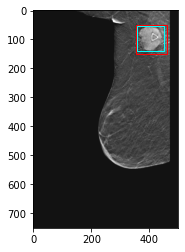

In [45]:
# [STAR] Code to compare the ground truth and predicted mask

import matplotlib.patches as patches

case_index        = random.randint(0, len(valid_dataset)-1)
images, b, c = valid_dataset[case_index]

print('Ground Truth ', b['boxes'].data.cpu().numpy())

plt.imshow(images[0], cmap='gray')
ax   = plt.gca()

if(len(all_target1[case_index]) > 0):
    #print(all_target1[index])
    #print(all_scores1[index])
    
    temp  = all_target1[case_index]
    index = 0
    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='yellow', fill = False)
    ax.add_patch(rect)
else:
    print('Not found 9')

if(len(all_target[case_index]) > 0):
    #print(all_target[index])
    #print(all_scores[index])
    
    temp  = all_target[case_index]
    index = 0
    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
    ax.add_patch(rect)
else:
    print('Not found 8')

temp  = b['boxes'].data.cpu().numpy()#all_target[index]
index = 0
rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='red', fill = False)
ax.add_patch(rect)


#rect = patches.Rectangle((0, 0), 500, 100, linewidth=2, edgecolor='cyan', fill = False)

plt.show()


In [ ]:
# [STAR] For doing the inference on the test images

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [91]:
# Some code to do visualization


BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

fp    = "/home/yu-hao/Downloads/coco_sample.png"
image = cv2.imread(fp)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

(375, 500, 3)


In [ ]:
# [STAR] Plot image 1

import matplotlib.patches as patches

#train_dataset1     = DBTDataset(train_set=1)
#index = random.randint(0, len(train_dataset)-1)
#image, b, c = train_dataset[index]

case_index       = random.randint(0, len(train_dataset)-1)
image, b, c = train_dataset[case_index]
image       = np.moveaxis(image, 0, -1)

# transform = A.Compose(
#     [A.HorizontalFlip(p=0.95)],
#     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
# )

# temp_box = b['boxes'].data.cpu().numpy()

# temp_box[0][0] = temp_box[0][0]
# temp_box[0][2] = temp_box[0][2]
# temp_box[0][3] = temp_box[0][3]
# temp_box[0][1] = temp_box[0][1]

# random.seed(7)
# transformed = transform(image=image, bboxes=temp_box, labels=b['labels'])

plt.imshow(image)
ax   = plt.gca()

temp  = b['boxes']#b[index]
index = 0
rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
ax.add_patch(rect)

In [ ]:
# [STAR] Some code to test the augmentation

import matplotlib.patches as patches

#case_index  = random.randint(0, len(valid_dataset)-1)
image, b, c = valid_dataset[case_index]
image       = np.moveaxis(image, 0, -1)

transform = A.Compose(
    #[A.HorizontalFlip(p=0.99)],
    [A.VerticalFlip(p=0.99)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)

temp_box       = b['boxes'].data.cpu().numpy()

temp_box[0][0] = temp_box[0][0]
temp_box[0][2] = temp_box[0][2]
temp_box[0][3] = temp_box[0][3]
temp_box[0][1] = temp_box[0][1]
temp           = temp_box

if(0):
    transformed = transform(image=image, bboxes=temp_box, labels=b['labels'])
    image    = transformed['image']
    temp     = transformed['bboxes']

plt.imshow(image)
ax    = plt.gca()
index = 0
rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
ax.add_patch(rect)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, targets, image_ids = next(iter(train_data_loader))
images  = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes  = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

In [ ]:
# [STAR] For plotting the images

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [138]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = DBTDataset()
#valid_dataset = DBTDataset()


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

# valid_data_loader = DataLoader(
#     valid_dataset,
#     batch_size=8,
#     shuffle=False,
#     num_workers=4,
#     collate_fn=collate_fn
# )

In [143]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

num_classes = 2

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.5)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 20

In [ ]:
num_epochs = 2000

loss_hist = Averager()
itr = 1
#train_dataset = td1
#model.train()
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for k in range(len(train_dataset)-1):
        images, targets, image_ids = train_dataset[k]
        #for images, targets, image_ids in train_data_loader:
        #print(images, targets)
        
        images  = [images]
        targets = [targets]
        #images  = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        
        loss_dict = model(images, targets)
        
        #losses = loss_dict['loss_rpn_box_reg'] + loss_dict['loss_objectness']
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(loss_dict)
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 

In [121]:
print(targets)

[{'boxes': tensor([[  76., 1665.,  254., 1791.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([156]), 'area': tensor([22428.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]


In [107]:
model.eval()

images, targets, image_ids = train_dataset[k]
images  = [images]
targets = [targets]

loss_dict = model(images)
        

In [9]:
img_list_path   = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train.txt"

train_cate_path = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train_cate.txt"
train_attr_path = "/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Anno_fine/train_attr.txt"


img_list = open(img_list_path).read()
img_list = img_list.split("\n")[:-1]

print(len(img_list))
basepath = ""

for i in tqdm(range(len(img_list))):
    #print(img_list[i])
    img_path = basepath+"/media/yu-hao/WindowsData/MMFASHION-DATASET/CategoryandAttributePredictionBenchmark/Img/"+img_list[i]
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    #print(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    
    print(image.shape)

  0%|          | 0/14000 [00:00<?, ?it/s]

14000
(300, 300, 3)
(300, 200, 3)
(300, 241, 3)
(300, 200, 3)
(300, 257, 3)
(300, 205, 3)
(300, 215, 3)
(300, 206, 3)
(300, 205, 3)
(300, 236, 3)
(301, 201, 3)
(300, 300, 3)
(225, 300, 3)
(300, 225, 3)
(300, 240, 3)
(301, 205, 3)
(300, 300, 3)
(300, 222, 3)
(300, 200, 3)
(300, 205, 3)
(300, 200, 3)
(300, 196, 3)
(300, 300, 3)
(300, 199, 3)
(300, 300, 3)
(300, 211, 3)
(300, 205, 3)
(300, 236, 3)
(300, 217, 3)
(301, 244, 3)
(301, 225, 3)
(301, 240, 3)
(300, 205, 3)
(300, 201, 3)
(300, 240, 3)
(300, 258, 3)
(300, 222, 3)
(300, 229, 3)
(300, 221, 3)
(300, 170, 3)
(300, 210, 3)
(301, 199, 3)
(300, 235, 3)
(300, 300, 3)
(300, 236, 3)
(300, 210, 3)
(300, 205, 3)
(300, 234, 3)
(301, 199, 3)
(300, 197, 3)
(300, 250, 3)
(300, 300, 3)
(300, 228, 3)
(300, 208, 3)
(301, 301, 3)
(300, 180, 3)
(301, 205, 3)
(301, 205, 3)
(300, 300, 3)
(300, 205, 3)
(300, 225, 3)
(300, 226, 3)
(300, 300, 3)
(300, 218, 3)
(300, 225, 3)
(300, 231, 3)
(301, 199, 3)
(300, 200, 3)
(300, 250, 3)
(300, 205, 3)
(300, 300, 3)


  1%|          | 86/14000 [00:00<03:06, 74.60it/s] 

(300, 300, 3)
(300, 201, 3)
(300, 225, 3)
(300, 240, 3)
(300, 196, 3)
(300, 170, 3)
(300, 196, 3)


  1%|          | 97/14000 [00:00<04:15, 54.38it/s]

(300, 300, 3)
(300, 205, 3)
(300, 190, 3)
(300, 200, 3)
(300, 254, 3)
(300, 300, 3)
(300, 236, 3)
(300, 205, 3)
(301, 222, 3)
(300, 221, 3)
(301, 199, 3)


  1%|          | 108/14000 [00:01<04:25, 52.30it/s]

(300, 241, 3)
(300, 110, 3)
(300, 300, 3)
(300, 200, 3)
(300, 205, 3)
(300, 234, 3)
(300, 205, 3)
(300, 229, 3)
(300, 225, 3)
(300, 225, 3)
(300, 205, 3)


  1%|          | 114/14000 [00:01<04:23, 52.65it/s]

(300, 300, 3)
(300, 300, 3)
(301, 244, 3)
(301, 259, 3)
(300, 234, 3)
(300, 196, 3)
(300, 225, 3)
(300, 231, 3)
(300, 300, 3)
(300, 236, 3)


  1%|          | 125/14000 [00:01<05:07, 45.16it/s]

(300, 257, 3)
(300, 200, 3)
(300, 236, 3)
(300, 300, 3)
(300, 158, 3)
(301, 251, 3)
(300, 236, 3)
(300, 215, 3)


  1%|          | 136/14000 [00:01<05:10, 44.68it/s]

(300, 300, 3)
(300, 221, 3)
(300, 205, 3)
(300, 207, 3)
(300, 300, 3)
(301, 244, 3)
(300, 300, 3)
(300, 200, 3)
(225, 300, 3)
(300, 200, 3)


  1%|          | 141/14000 [00:01<05:07, 45.04it/s]

(300, 225, 3)
(300, 196, 3)
(300, 196, 3)
(300, 262, 3)
(301, 205, 3)
(300, 225, 3)
(300, 296, 3)
(300, 205, 3)
(300, 240, 3)
(300, 200, 3)


  1%|          | 152/14000 [00:02<06:10, 37.40it/s]

(300, 223, 3)
(300, 236, 3)
(300, 235, 3)
(300, 200, 3)
(300, 205, 3)
(300, 236, 3)


  1%|          | 160/14000 [00:02<06:24, 36.01it/s]

(301, 244, 3)
(300, 200, 3)
(300, 200, 3)
(300, 246, 3)
(301, 205, 3)
(300, 236, 3)
(300, 200, 3)
(301, 205, 3)


  1%|          | 164/14000 [00:02<06:46, 34.04it/s]

(300, 200, 3)
(300, 300, 3)
(300, 300, 3)
(300, 236, 3)
(300, 258, 3)
(300, 236, 3)


  1%|          | 172/14000 [00:02<07:14, 31.81it/s]

(300, 208, 3)
(300, 300, 3)
(300, 201, 3)
(300, 225, 3)
(300, 248, 3)
(301, 244, 3)
(301, 205, 3)


  1%|▏         | 181/14000 [00:03<06:41, 34.42it/s]

(300, 205, 3)
(300, 200, 3)
(300, 205, 3)
(300, 300, 3)
(300, 196, 3)
(301, 199, 3)
(300, 300, 3)
(300, 223, 3)
(300, 205, 3)
(300, 240, 3)


  1%|▏         | 190/14000 [00:03<06:05, 37.82it/s]

(300, 225, 3)
(300, 236, 3)
(300, 200, 3)
(300, 236, 3)
(300, 300, 3)
(300, 205, 3)
(301, 221, 3)


  1%|▏         | 194/14000 [00:03<07:44, 29.71it/s]

(300, 236, 3)
(300, 200, 3)
(300, 151, 3)
(300, 200, 3)
(300, 200, 3)
(300, 225, 3)


  1%|▏         | 203/14000 [00:03<06:44, 34.08it/s]

(300, 300, 3)
(300, 199, 3)
(300, 196, 3)
(300, 236, 3)
(301, 244, 3)
(301, 244, 3)
(300, 205, 3)
(300, 191, 3)
(300, 200, 3)


  2%|▏         | 212/14000 [00:03<06:16, 36.62it/s]

(300, 236, 3)
(301, 205, 3)
(300, 207, 3)
(300, 246, 3)
(300, 205, 3)
(300, 235, 3)
(300, 200, 3)
(301, 205, 3)
(300, 225, 3)
(300, 180, 3)


  2%|▏         | 222/14000 [00:04<05:35, 41.08it/s]

(300, 211, 3)
(300, 205, 3)
(300, 243, 3)
(301, 205, 3)
(300, 300, 3)
(300, 191, 3)
(288, 300, 3)
(301, 225, 3)
(300, 300, 3)
(301, 205, 3)


  2%|▏         | 233/14000 [00:04<05:06, 44.94it/s]

(300, 300, 3)
(300, 205, 3)
(301, 235, 3)
(300, 201, 3)
(300, 262, 3)
(300, 225, 3)
(300, 258, 3)
(300, 300, 3)
(300, 200, 3)


  2%|▏         | 238/14000 [00:04<05:41, 40.26it/s]

(300, 201, 3)
(300, 300, 3)
(300, 225, 3)
(300, 225, 3)
(300, 205, 3)
(300, 240, 3)
(300, 231, 3)


  2%|▏         | 248/14000 [00:04<05:57, 38.45it/s]

(300, 219, 3)
(300, 200, 3)
(300, 188, 3)
(300, 180, 3)
(300, 208, 3)
(300, 205, 3)
(301, 201, 3)
(300, 200, 3)


  2%|▏         | 252/14000 [00:04<05:57, 38.49it/s]

(300, 200, 3)
(301, 201, 3)
(300, 215, 3)
(300, 236, 3)
(300, 201, 3)
(300, 200, 3)


  2%|▏         | 260/14000 [00:05<06:49, 33.58it/s]

(300, 236, 3)
(300, 300, 3)
(300, 221, 3)
(300, 300, 3)
(300, 300, 3)
(300, 240, 3)
(300, 250, 3)
(300, 236, 3)


  2%|▏         | 270/14000 [00:05<05:51, 39.09it/s]

(300, 236, 3)
(300, 190, 3)
(300, 288, 3)
(300, 300, 3)
(300, 200, 3)
(300, 257, 3)
(300, 240, 3)
(301, 200, 3)
(300, 205, 3)
(300, 231, 3)
(300, 200, 3)
(300, 225, 3)
(300, 300, 3)


  2%|▏         | 282/14000 [00:05<06:08, 37.21it/s]

(300, 200, 3)
(200, 300, 3)
(300, 258, 3)
(225, 300, 3)
(300, 236, 3)
(300, 200, 3)


  2%|▏         | 287/14000 [00:05<06:37, 34.48it/s]

(286, 301, 3)
(300, 271, 3)
(300, 237, 3)
(262, 300, 3)
(300, 200, 3)
(300, 200, 3)


  2%|▏         | 295/14000 [00:06<06:59, 32.63it/s]

(202, 300, 3)
(300, 205, 3)
(300, 300, 3)
(300, 241, 3)
(300, 276, 3)
(300, 300, 3)
(300, 300, 3)


  2%|▏         | 299/14000 [00:06<07:06, 32.12it/s]

(300, 200, 3)
(300, 200, 3)
(300, 236, 3)
(300, 235, 3)
(300, 200, 3)
(300, 196, 3)
(300, 300, 3)


  2%|▏         | 307/14000 [00:06<07:06, 32.14it/s]

(301, 301, 3)
(300, 210, 3)
(238, 300, 3)
(301, 205, 3)
(300, 240, 3)
(301, 238, 3)
(300, 236, 3)
(300, 210, 3)
(300, 205, 3)


  2%|▏         | 317/14000 [00:06<06:23, 35.68it/s]

(300, 300, 3)
(300, 200, 3)
(225, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 236, 3)


  2%|▏         | 321/14000 [00:07<08:25, 27.05it/s]

(300, 231, 3)
(300, 225, 3)
(300, 246, 3)
(300, 225, 3)
(300, 198, 3)


  2%|▏         | 325/14000 [00:07<08:53, 25.65it/s]

(301, 251, 3)
(300, 250, 3)
(300, 255, 3)
(300, 234, 3)
(300, 205, 3)
(301, 205, 3)
(300, 300, 3)


  2%|▏         | 334/14000 [00:07<08:00, 28.42it/s]

(300, 300, 3)
(300, 200, 3)
(301, 201, 3)
(300, 240, 3)
(300, 174, 3)
(301, 200, 3)
(300, 300, 3)
(300, 246, 3)


  2%|▏         | 341/14000 [00:07<09:37, 23.64it/s]

(300, 236, 3)
(301, 244, 3)
(300, 200, 3)
(300, 236, 3)
(300, 236, 3)
(300, 300, 3)
(300, 219, 3)
(301, 225, 3)


  3%|▎         | 353/14000 [00:08<07:01, 32.36it/s]

(300, 225, 3)
(300, 226, 3)
(300, 300, 3)
(301, 201, 3)
(301, 301, 3)
(300, 300, 3)
(300, 225, 3)
(300, 236, 3)
(300, 250, 3)
(300, 225, 3)
(300, 225, 3)


  3%|▎         | 364/14000 [00:08<05:49, 38.98it/s]

(300, 248, 3)
(300, 300, 3)
(300, 300, 3)
(301, 244, 3)
(300, 236, 3)
(300, 200, 3)
(300, 285, 3)
(300, 233, 3)
(300, 200, 3)
(300, 173, 3)


  3%|▎         | 369/14000 [00:08<05:43, 39.70it/s]

(301, 205, 3)
(300, 200, 3)
(300, 205, 3)
(300, 236, 3)
(300, 236, 3)
(300, 200, 3)
(300, 236, 3)


  3%|▎         | 379/14000 [00:08<05:54, 38.40it/s]

(301, 244, 3)
(300, 208, 3)
(300, 236, 3)
(300, 236, 3)
(300, 216, 3)
(300, 224, 3)
(300, 205, 3)
(300, 205, 3)


  3%|▎         | 384/14000 [00:08<08:07, 27.93it/s]

(300, 237, 3)
(300, 200, 3)
(300, 300, 3)
(300, 225, 3)
(300, 188, 3)
(300, 199, 3)
(300, 250, 3)


  3%|▎         | 394/14000 [00:09<06:25, 35.26it/s]

(300, 200, 3)
(300, 236, 3)
(300, 225, 3)
(300, 205, 3)
(300, 300, 3)
(300, 205, 3)
(295, 300, 3)
(301, 226, 3)
(300, 209, 3)
(300, 210, 3)


  3%|▎         | 404/14000 [00:09<06:39, 34.00it/s]

(300, 200, 3)
(301, 301, 3)
(300, 200, 3)
(300, 300, 3)
(300, 256, 3)
(300, 200, 3)


  3%|▎         | 409/14000 [00:09<06:13, 36.41it/s]

(300, 225, 3)
(300, 196, 3)
(300, 258, 3)
(300, 213, 3)
(300, 200, 3)
(300, 200, 3)
(300, 205, 3)
(300, 208, 3)
(300, 236, 3)
(301, 220, 3)


  3%|▎         | 420/14000 [00:09<05:35, 40.44it/s]

(300, 211, 3)
(300, 257, 3)
(200, 300, 3)
(300, 240, 3)
(300, 200, 3)
(300, 236, 3)
(300, 236, 3)
(300, 200, 3)
(300, 200, 3)


  3%|▎         | 430/14000 [00:10<05:27, 41.49it/s]

(300, 200, 3)
(300, 201, 3)
(300, 205, 3)
(300, 191, 3)
(300, 200, 3)
(300, 236, 3)
(300, 205, 3)
(300, 200, 3)
(301, 205, 3)


  3%|▎         | 435/14000 [00:10<05:19, 42.50it/s]

(301, 201, 3)
(300, 200, 3)
(300, 196, 3)
(300, 205, 3)
(300, 200, 3)
(300, 258, 3)
(300, 205, 3)


  3%|▎         | 445/14000 [00:10<05:50, 38.69it/s]

(300, 300, 3)
(300, 206, 3)
(300, 300, 3)
(300, 236, 3)
(300, 205, 3)
(300, 210, 3)
(300, 200, 3)
(300, 200, 3)
(300, 240, 3)
(301, 201, 3)


  3%|▎         | 455/14000 [00:10<06:22, 35.45it/s]

(300, 225, 3)
(300, 205, 3)
(300, 205, 3)
(300, 216, 3)
(300, 205, 3)
(300, 258, 3)


  3%|▎         | 464/14000 [00:11<06:06, 36.93it/s]

(300, 200, 3)
(300, 234, 3)
(300, 196, 3)
(300, 200, 3)
(300, 190, 3)
(300, 225, 3)
(300, 300, 3)
(300, 226, 3)
(300, 223, 3)
(300, 258, 3)
(300, 300, 3)
(301, 191, 3)


  3%|▎         | 470/14000 [00:11<05:29, 41.05it/s]

(300, 246, 3)
(300, 232, 3)
(300, 300, 3)
(300, 200, 3)
(300, 300, 3)
(300, 200, 3)


  3%|▎         | 475/14000 [00:11<06:08, 36.69it/s]

(300, 282, 3)
(300, 179, 3)
(300, 232, 3)
(300, 258, 3)
(300, 205, 3)


  3%|▎         | 483/14000 [00:11<07:25, 30.32it/s]

(300, 208, 3)
(301, 199, 3)
(300, 300, 3)
(300, 240, 3)
(301, 205, 3)
(300, 200, 3)
(300, 190, 3)
(300, 231, 3)


  4%|▎         | 494/14000 [00:11<06:08, 36.64it/s]

(301, 244, 3)
(300, 225, 3)
(300, 200, 3)
(300, 205, 3)
(300, 205, 3)
(300, 208, 3)
(301, 205, 3)
(300, 205, 3)


  4%|▎         | 499/14000 [00:12<06:24, 35.15it/s]

(300, 188, 3)
(300, 205, 3)
(300, 193, 3)
(300, 276, 3)
(301, 205, 3)
(301, 199, 3)
(300, 219, 3)
(301, 201, 3)
(300, 200, 3)


  4%|▎         | 508/14000 [00:12<07:38, 29.45it/s]

(300, 236, 3)
(300, 200, 3)
(300, 246, 3)
(301, 201, 3)
(300, 300, 3)
(300, 300, 3)


  4%|▎         | 518/14000 [00:12<06:15, 35.86it/s]

(300, 200, 3)
(300, 225, 3)
(300, 231, 3)
(300, 201, 3)
(301, 205, 3)
(301, 225, 3)
(300, 300, 3)
(300, 200, 3)
(300, 254, 3)
(300, 293, 3)


  4%|▎         | 523/14000 [00:12<05:47, 38.76it/s]

(301, 199, 3)
(300, 174, 3)
(300, 236, 3)
(300, 300, 3)
(300, 200, 3)
(300, 200, 3)


  4%|▍         | 533/14000 [00:12<06:09, 36.49it/s]

(300, 186, 3)
(300, 208, 3)
(300, 200, 3)
(300, 248, 3)
(300, 200, 3)
(300, 236, 3)
(300, 205, 3)
(300, 224, 3)
(300, 200, 3)
(300, 200, 3)


  4%|▍         | 542/14000 [00:13<05:46, 38.89it/s]

(233, 300, 3)
(301, 205, 3)
(300, 200, 3)
(300, 300, 3)
(301, 205, 3)
(300, 220, 3)
(300, 210, 3)
(301, 205, 3)
(300, 200, 3)


  4%|▍         | 552/14000 [00:13<05:25, 41.35it/s]

(301, 244, 3)
(300, 213, 3)
(300, 200, 3)
(300, 200, 3)
(300, 258, 3)
(300, 200, 3)
(300, 300, 3)
(300, 236, 3)
(300, 200, 3)


  4%|▍         | 562/14000 [00:13<05:13, 42.82it/s]

(301, 199, 3)
(300, 258, 3)
(300, 241, 3)
(300, 202, 3)
(300, 300, 3)
(300, 226, 3)
(300, 236, 3)
(301, 244, 3)
(300, 196, 3)
(301, 205, 3)


  4%|▍         | 572/14000 [00:13<05:17, 42.28it/s]

(300, 210, 3)
(301, 244, 3)
(300, 151, 3)
(300, 200, 3)
(300, 205, 3)
(300, 225, 3)
(300, 240, 3)
(301, 199, 3)
(300, 201, 3)


  4%|▍         | 577/14000 [00:14<05:10, 43.29it/s]

(300, 199, 3)
(300, 200, 3)
(300, 205, 3)
(300, 200, 3)
(300, 210, 3)
(300, 200, 3)
(300, 200, 3)
(300, 300, 3)
(300, 208, 3)


  4%|▍         | 587/14000 [00:14<05:22, 41.54it/s]

(300, 200, 3)
(300, 300, 3)
(300, 300, 3)
(300, 225, 3)
(300, 236, 3)
(300, 205, 3)
(300, 258, 3)
(300, 236, 3)
(300, 205, 3)


  4%|▍         | 598/14000 [00:14<05:21, 41.72it/s]

(300, 258, 3)
(300, 210, 3)
(300, 250, 3)
(300, 258, 3)
(300, 205, 3)
(300, 236, 3)
(301, 205, 3)
(300, 210, 3)


  4%|▍         | 603/14000 [00:14<05:24, 41.34it/s]

(300, 200, 3)
(300, 205, 3)
(300, 196, 3)
(300, 300, 3)
(300, 300, 3)
(300, 200, 3)
(300, 300, 3)
(300, 205, 3)
(301, 199, 3)


  4%|▍         | 613/14000 [00:14<05:14, 42.54it/s]

(300, 201, 3)
(300, 169, 3)
(300, 236, 3)
(300, 205, 3)
(300, 200, 3)
(300, 205, 3)
(300, 300, 3)
(300, 235, 3)


  4%|▍         | 623/14000 [00:15<05:11, 42.97it/s]

(300, 286, 3)
(300, 208, 3)
(300, 208, 3)
(300, 300, 3)
(300, 205, 3)
(300, 248, 3)
(300, 200, 3)
(300, 300, 3)
(301, 205, 3)
(300, 258, 3)


  5%|▍         | 633/14000 [00:15<04:59, 44.63it/s]

(300, 236, 3)
(300, 201, 3)
(300, 200, 3)
(300, 205, 3)
(300, 208, 3)
(300, 236, 3)
(300, 243, 3)
(300, 221, 3)
(300, 200, 3)


  5%|▍         | 644/14000 [00:15<04:39, 47.76it/s]

(300, 248, 3)
(300, 225, 3)
(300, 300, 3)
(300, 200, 3)
(300, 200, 3)
(300, 200, 3)
(300, 205, 3)
(300, 205, 3)
(300, 148, 3)
(301, 205, 3)
(300, 240, 3)


  5%|▍         | 654/14000 [00:15<04:42, 47.18it/s]

(300, 205, 3)
(300, 205, 3)
(300, 196, 3)
(300, 225, 3)
(300, 300, 3)
(301, 221, 3)
(300, 175, 3)
(300, 205, 3)
(300, 205, 3)
(300, 300, 3)


  5%|▍         | 664/14000 [00:15<05:05, 43.68it/s]

(300, 231, 3)
(300, 240, 3)
(300, 200, 3)
(300, 205, 3)
(300, 201, 3)
(300, 226, 3)
(300, 224, 3)
(300, 246, 3)
(300, 258, 3)


  5%|▍         | 674/14000 [00:16<04:58, 44.70it/s]

(300, 300, 3)
(300, 200, 3)
(301, 205, 3)
(300, 201, 3)
(300, 300, 3)
(300, 200, 3)
(300, 247, 3)
(300, 220, 3)
(300, 236, 3)
(300, 300, 3)


  5%|▍         | 679/14000 [00:16<04:59, 44.44it/s]

(300, 200, 3)
(300, 205, 3)
(300, 200, 3)
(300, 200, 3)
(301, 301, 3)
(300, 200, 3)
(301, 241, 3)
(301, 205, 3)
(300, 240, 3)


  5%|▍         | 689/14000 [00:16<05:09, 43.06it/s]

(300, 236, 3)
(300, 300, 3)
(300, 203, 3)
(300, 250, 3)
(300, 191, 3)
(300, 300, 3)
(301, 244, 3)
(300, 196, 3)
(301, 205, 3)


  5%|▍         | 699/14000 [00:16<05:02, 43.92it/s]

(300, 208, 3)
(300, 215, 3)
(300, 200, 3)
(300, 216, 3)
(300, 216, 3)
(300, 258, 3)
(300, 238, 3)
(300, 236, 3)
(300, 200, 3)


  5%|▌         | 709/14000 [00:17<04:58, 44.59it/s]

(300, 180, 3)
(300, 205, 3)
(300, 205, 3)
(300, 300, 3)
(300, 258, 3)
(300, 210, 3)
(300, 231, 3)
(300, 231, 3)
(300, 167, 3)
(300, 236, 3)


  5%|▌         | 720/14000 [00:17<04:40, 47.38it/s]

(300, 300, 3)
(301, 244, 3)
(300, 223, 3)
(300, 223, 3)
(300, 205, 3)
(300, 205, 3)
(300, 236, 3)
(300, 225, 3)
(300, 225, 3)
(300, 225, 3)
(300, 300, 3)


  5%|▌         | 730/14000 [00:17<05:03, 43.76it/s]

(300, 208, 3)
(300, 230, 3)
(300, 258, 3)
(300, 226, 3)
(300, 205, 3)
(301, 244, 3)
(300, 219, 3)
(301, 205, 3)


  5%|▌         | 735/14000 [00:17<04:55, 44.83it/s]

(300, 300, 3)
(300, 236, 3)
(300, 236, 3)
(300, 200, 3)
(300, 179, 3)
(300, 200, 3)
(301, 199, 3)
(300, 180, 3)
(300, 225, 3)
(301, 292, 3)


  5%|▌         | 746/14000 [00:17<04:52, 45.27it/s]

(300, 170, 3)
(300, 223, 3)
(300, 208, 3)
(300, 236, 3)
(300, 300, 3)
(300, 236, 3)
(300, 188, 3)
(300, 300, 3)
(300, 200, 3)


  5%|▌         | 757/14000 [00:18<04:44, 46.58it/s]

(300, 219, 3)
(300, 236, 3)
(300, 196, 3)
(301, 201, 3)
(300, 201, 3)
(300, 196, 3)
(300, 200, 3)
(300, 205, 3)
(300, 204, 3)
(300, 196, 3)
(300, 200, 3)


  5%|▌         | 767/14000 [00:18<04:47, 46.08it/s]

(300, 236, 3)
(300, 205, 3)
(300, 201, 3)
(300, 205, 3)
(300, 205, 3)
(300, 205, 3)
(300, 300, 3)
(301, 225, 3)
(300, 243, 3)
(300, 300, 3)


  6%|▌         | 777/14000 [00:18<04:47, 46.07it/s]

(300, 205, 3)
(300, 201, 3)
(300, 246, 3)
(300, 205, 3)
(300, 185, 3)
(300, 225, 3)
(300, 205, 3)
(300, 258, 3)
(300, 196, 3)
(300, 236, 3)


  6%|▌         | 787/14000 [00:18<04:54, 44.88it/s]

(300, 205, 3)
(225, 300, 3)
(300, 225, 3)
(300, 200, 3)
(301, 244, 3)
(300, 225, 3)
(300, 207, 3)
(300, 236, 3)
(300, 225, 3)


  6%|▌         | 797/14000 [00:18<05:07, 42.95it/s]

(300, 205, 3)
(300, 257, 3)
(300, 300, 3)
(300, 200, 3)
(300, 205, 3)
(300, 199, 3)
(300, 205, 3)
(225, 300, 3)
(301, 205, 3)


  6%|▌         | 808/14000 [00:19<04:44, 46.30it/s]

(301, 201, 3)
(300, 200, 3)
(300, 236, 3)
(300, 300, 3)
(301, 301, 3)
(300, 200, 3)
(300, 200, 3)
(300, 300, 3)
(300, 200, 3)
(300, 200, 3)


  6%|▌         | 813/14000 [00:19<04:56, 44.43it/s]

(300, 300, 3)
(300, 200, 3)
(300, 240, 3)
(301, 205, 3)
(300, 300, 3)
(300, 191, 3)
(300, 200, 3)
(300, 236, 3)
(300, 240, 3)
(300, 215, 3)


  6%|▌         | 824/14000 [00:19<04:59, 43.99it/s]

(300, 246, 3)
(300, 236, 3)
(300, 200, 3)
(300, 209, 3)
(300, 200, 3)
(300, 240, 3)
(300, 221, 3)
(300, 201, 3)


  6%|▌         | 834/14000 [00:19<05:17, 41.43it/s]

(300, 225, 3)
(300, 238, 3)
(300, 220, 3)
(300, 300, 3)
(300, 300, 3)
(300, 178, 3)
(300, 200, 3)
(300, 236, 3)
(300, 300, 3)


  6%|▌         | 845/14000 [00:20<04:51, 45.18it/s]

(301, 244, 3)
(300, 205, 3)
(300, 205, 3)
(300, 200, 3)
(300, 300, 3)
(300, 225, 3)
(300, 205, 3)
(300, 225, 3)
(300, 200, 3)
(300, 195, 3)


  6%|▌         | 850/14000 [00:20<04:51, 45.08it/s]

(301, 244, 3)
(300, 210, 3)
(300, 200, 3)
(300, 228, 3)
(300, 200, 3)
(300, 300, 3)
(300, 240, 3)
(300, 205, 3)
(300, 236, 3)


  6%|▌         | 862/14000 [00:20<04:33, 48.07it/s]

(300, 300, 3)
(300, 250, 3)
(300, 200, 3)
(300, 225, 3)
(300, 210, 3)
(300, 210, 3)
(300, 208, 3)
(300, 300, 3)
(301, 238, 3)
(300, 300, 3)
(300, 236, 3)


  6%|▌         | 872/14000 [00:20<04:52, 44.92it/s]

(300, 225, 3)
(300, 236, 3)
(301, 205, 3)
(300, 205, 3)
(301, 199, 3)
(300, 200, 3)
(300, 225, 3)
(300, 205, 3)
(225, 300, 3)


  6%|▋         | 882/14000 [00:20<04:53, 44.65it/s]

(300, 200, 3)
(301, 205, 3)
(300, 200, 3)
(300, 205, 3)
(300, 196, 3)
(300, 250, 3)
(300, 139, 3)
(300, 236, 3)
(300, 199, 3)


  6%|▋         | 892/14000 [00:21<04:58, 43.94it/s]

(300, 300, 3)
(300, 300, 3)
(300, 205, 3)
(300, 300, 3)
(300, 210, 3)
(300, 300, 3)
(300, 196, 3)
(300, 204, 3)
(301, 228, 3)


  6%|▋         | 897/14000 [00:21<05:04, 43.10it/s]

(300, 225, 3)
(300, 240, 3)
(300, 300, 3)
(300, 196, 3)
(300, 250, 3)
(300, 205, 3)
(301, 201, 3)
(300, 150, 3)
(300, 250, 3)


  6%|▋         | 907/14000 [00:21<05:18, 41.13it/s]

(300, 236, 3)
(300, 200, 3)
(300, 205, 3)
(301, 205, 3)
(300, 300, 3)
(300, 200, 3)
(301, 205, 3)
(300, 200, 3)


  7%|▋         | 917/14000 [00:21<05:16, 41.40it/s]

(300, 200, 3)
(301, 226, 3)
(300, 246, 3)
(300, 205, 3)
(300, 223, 3)
(301, 200, 3)
(300, 236, 3)
(300, 243, 3)
(300, 234, 3)


  7%|▋         | 926/14000 [00:21<05:33, 39.26it/s]

(300, 200, 3)
(300, 200, 3)
(300, 225, 3)
(300, 300, 3)
(300, 236, 3)
(300, 236, 3)
(300, 205, 3)
(300, 218, 3)


  7%|▋         | 930/14000 [00:22<05:42, 38.12it/s]

(300, 300, 3)
(300, 216, 3)
(300, 229, 3)
(300, 300, 3)
(300, 200, 3)
(300, 208, 3)
(301, 244, 3)
(300, 300, 3)


  7%|▋         | 940/14000 [00:22<05:17, 41.15it/s]

(301, 235, 3)
(300, 233, 3)
(300, 246, 3)
(300, 200, 3)
(300, 208, 3)
(300, 257, 3)
(301, 244, 3)
(300, 300, 3)
(300, 196, 3)
(301, 201, 3)


  7%|▋         | 950/14000 [00:22<05:19, 40.80it/s]

(301, 199, 3)
(301, 201, 3)
(300, 200, 3)
(300, 200, 3)
(301, 244, 3)
(300, 300, 3)
(300, 200, 3)
(300, 210, 3)
(300, 208, 3)


  7%|▋         | 960/14000 [00:22<04:54, 44.30it/s]

(300, 205, 3)
(300, 200, 3)
(300, 205, 3)
(300, 170, 3)
(301, 205, 3)
(300, 225, 3)
(300, 240, 3)
(301, 299, 3)
(301, 201, 3)
(300, 210, 3)


  7%|▋         | 970/14000 [00:22<05:03, 42.97it/s]

(300, 200, 3)
(300, 190, 3)
(300, 300, 3)
(300, 300, 3)
(300, 215, 3)
(300, 236, 3)
(300, 258, 3)
(300, 200, 3)
(301, 169, 3)


  7%|▋         | 981/14000 [00:23<04:56, 43.94it/s]

(300, 236, 3)
(300, 236, 3)
(300, 205, 3)
(300, 170, 3)
(300, 238, 3)
(300, 200, 3)
(300, 200, 3)
(300, 205, 3)
(300, 236, 3)


  7%|▋         | 986/14000 [00:23<05:07, 42.37it/s]

(300, 200, 3)
(300, 219, 3)
(225, 300, 3)
(300, 258, 3)
(300, 205, 3)
(300, 236, 3)
(301, 225, 3)
(300, 205, 3)
(300, 238, 3)


  7%|▋         | 996/14000 [00:23<04:55, 43.95it/s]

(300, 300, 3)
(300, 201, 3)
(300, 300, 3)
(300, 196, 3)
(300, 208, 3)
(301, 201, 3)
(300, 258, 3)
(300, 200, 3)
(301, 199, 3)
(300, 226, 3)


  7%|▋         | 1006/14000 [00:23<05:01, 43.06it/s]

(300, 300, 3)
(300, 205, 3)
(301, 205, 3)
(300, 223, 3)
(301, 205, 3)
(301, 205, 3)
(300, 196, 3)
(301, 199, 3)
(300, 200, 3)


  7%|▋         | 1016/14000 [00:23<05:12, 41.54it/s]

(300, 300, 3)
(300, 200, 3)
(301, 205, 3)
(300, 300, 3)
(300, 208, 3)
(300, 300, 3)
(301, 205, 3)
(300, 200, 3)
(300, 300, 3)


  7%|▋         | 1027/14000 [00:24<04:39, 46.33it/s]

(300, 225, 3)
(300, 209, 3)
(300, 200, 3)
(300, 205, 3)
(300, 236, 3)
(300, 225, 3)
(300, 246, 3)
(300, 215, 3)
(300, 240, 3)
(300, 205, 3)


  7%|▋         | 1037/14000 [00:24<04:53, 44.15it/s]

(300, 240, 3)
(300, 181, 3)
(300, 300, 3)
(300, 200, 3)
(300, 190, 3)
(300, 236, 3)
(268, 300, 3)
(300, 300, 3)
(300, 200, 3)
(300, 200, 3)


  7%|▋         | 1047/14000 [00:24<04:43, 45.72it/s]

(300, 300, 3)
(301, 237, 3)
(300, 196, 3)
(300, 200, 3)
(300, 208, 3)
(300, 206, 3)
(300, 205, 3)
(300, 221, 3)
(300, 300, 3)
(300, 200, 3)


  8%|▊         | 1057/14000 [00:24<04:50, 44.48it/s]

(300, 169, 3)
(254, 300, 3)
(300, 164, 3)
(300, 225, 3)
(300, 170, 3)
(300, 225, 3)
(300, 300, 3)
(300, 200, 3)
(300, 300, 3)


  8%|▊         | 1067/14000 [00:25<04:40, 46.04it/s]

(300, 197, 3)
(300, 225, 3)
(301, 205, 3)
(300, 200, 3)
(301, 201, 3)
(300, 205, 3)
(300, 249, 3)
(300, 200, 3)
(300, 214, 3)
(300, 240, 3)


  8%|▊         | 1072/14000 [00:25<04:57, 43.39it/s]

(300, 246, 3)
(300, 300, 3)
(300, 200, 3)
(300, 231, 3)
(300, 200, 3)
(300, 200, 3)
(300, 250, 3)
(300, 200, 3)


  8%|▊         | 1082/14000 [00:25<04:59, 43.10it/s]

(300, 200, 3)
(300, 177, 3)
(300, 300, 3)
(300, 225, 3)
(300, 200, 3)
(189, 300, 3)
(300, 200, 3)
(300, 258, 3)
(301, 205, 3)


  8%|▊         | 1092/14000 [00:25<05:07, 42.00it/s]

(300, 205, 3)
(300, 236, 3)
(300, 196, 3)
(301, 301, 3)
(300, 300, 3)
(300, 230, 3)
(301, 205, 3)
(300, 257, 3)
(300, 201, 3)


  8%|▊         | 1104/14000 [00:25<04:41, 45.81it/s]

(300, 236, 3)
(300, 260, 3)
(301, 301, 3)
(300, 211, 3)
(301, 226, 3)
(300, 238, 3)
(301, 205, 3)
(300, 257, 3)
(300, 201, 3)
(300, 202, 3)
(300, 200, 3)


  8%|▊         | 1115/14000 [00:26<04:21, 49.19it/s]

(300, 219, 3)
(300, 205, 3)
(300, 200, 3)
(301, 201, 3)
(300, 258, 3)
(300, 165, 3)
(300, 200, 3)
(300, 225, 3)
(300, 205, 3)
(300, 208, 3)
(300, 234, 3)


  8%|▊         | 1121/14000 [00:26<04:21, 49.24it/s]

(300, 225, 3)
(300, 246, 3)
(300, 300, 3)
(301, 244, 3)
(300, 223, 3)
(300, 236, 3)
(158, 300, 3)
(300, 219, 3)
(300, 200, 3)
(300, 200, 3)


  8%|▊         | 1131/14000 [00:26<04:43, 45.32it/s]

(300, 300, 3)
(300, 240, 3)
(300, 225, 3)
(300, 196, 3)
(300, 205, 3)
(300, 200, 3)
(300, 236, 3)
(300, 178, 3)
(300, 210, 3)
(300, 205, 3)


  8%|▊         | 1141/14000 [00:26<04:38, 46.14it/s]

(300, 200, 3)
(301, 205, 3)
(300, 205, 3)
(300, 200, 3)
(300, 210, 3)
(300, 190, 3)
(301, 288, 3)
(300, 248, 3)
(300, 300, 3)
(301, 205, 3)


  8%|▊         | 1151/14000 [00:26<04:36, 46.46it/s]

(300, 300, 3)
(300, 300, 3)
(300, 175, 3)
(300, 300, 3)
(300, 226, 3)
(300, 200, 3)
(300, 208, 3)
(300, 240, 3)
(300, 225, 3)
(301, 301, 3)


  8%|▊         | 1161/14000 [00:27<04:41, 45.64it/s]

(300, 225, 3)
(300, 200, 3)
(188, 300, 3)
(300, 205, 3)
(300, 300, 3)
(300, 200, 3)
(300, 300, 3)
(300, 210, 3)
(301, 301, 3)


  8%|▊         | 1172/14000 [00:27<04:37, 46.18it/s]

(300, 300, 3)
(300, 200, 3)
(300, 200, 3)
(300, 200, 3)
(301, 201, 3)
(300, 246, 3)
(300, 300, 3)
(300, 300, 3)
(300, 205, 3)
(300, 210, 3)


  8%|▊         | 1183/14000 [00:27<04:33, 46.86it/s]

(301, 205, 3)
(300, 211, 3)
(300, 208, 3)
(300, 242, 3)
(300, 200, 3)
(300, 200, 3)
(300, 208, 3)
(300, 200, 3)
(300, 225, 3)
(300, 300, 3)
(300, 190, 3)


  9%|▊         | 1193/14000 [00:27<05:20, 39.92it/s]

(300, 200, 3)
(300, 300, 3)
(301, 205, 3)
(300, 197, 3)
(300, 300, 3)
(300, 215, 3)
(300, 219, 3)
(300, 200, 3)


  9%|▊         | 1203/14000 [00:28<04:52, 43.76it/s]

(300, 204, 3)
(300, 236, 3)
(300, 196, 3)
(300, 241, 3)
(200, 300, 3)
(300, 236, 3)
(301, 244, 3)
(301, 205, 3)
(300, 236, 3)
(300, 225, 3)


  9%|▊         | 1204/14000 [00:28<04:59, 42.70it/s]

(300, 300, 3)


KeyboardInterrupt: 